In [109]:
"""Import libs"""
import os, sys, logging, json, yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict
from pathlib import Path
from dotenv import load_dotenv

In [110]:
#load config, loggers and set paths
load_dotenv()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

base_dir = Path(os.getcwd()).parent
config_file_path = os.getenv("CONFIG_YAML_PATH", "config.yaml")
config_file = base_dir / config_file_path

if not os.path.exists(config_file):
    logger.error(f"Configuration file not found: {config_file}")
    raise FileNotFoundError(f"Configuration file not found: {config_file}")

try:
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
except yaml.YAMLError as e:
    logger.error(f"Error parsing YAML configuration file: {e}")
    raise

logger.info(f"Configuration loaded from {config_file}: {config}")

attrition_data_path = base_dir / config['data_paths']['attrition_data']

logger.info(f"Attrition data path set to: {attrition_data_path}")

2025-12-02 06:53:36,141 - INFO - Configuration loaded from c:\Users\rahul\OneDrive\Desktop\GenAI\Bain_Case_Study\config.yaml: {'rag': {'chunk_size': 500, 'chunk_overlap': 50, 'retrieval_k': 10, 'reranker_top_k': 5, 'semantic_weight': 0.8, 'bm25_weight': 0.2, 'reranker_model': 'BAAI/bge-reranker-base'}, 'generation': {'temperature': 0.3, 'max_tokens': 500, 'top_p': 0.9}, 'paths': {'supporting_docs_folder': 'supporting_docs', 'processed_docs_folder': 'processed_docs', 'chroma_db_folder': 'chroma_db', 'data_folder': 'data'}, 'logging': {'level': 'INFO', 'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s'}, 'data_paths': {'attrition_data': 'data/employee_attrition.csv'}}
2025-12-02 06:53:36,142 - INFO - Attrition data path set to: c:\Users\rahul\OneDrive\Desktop\GenAI\Bain_Case_Study\data\employee_attrition.csv


In [111]:
# Load the dataset, clean in case of missing values, and do initial analysis
df = pd.read_csv(attrition_data_path)
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\nColumns:", list(df.columns))
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

"""Inital analysis of Attrition Column"""
print("\nAttrition Value Counts:")
print(df['Attrition'].value_counts())
print(f"Attrition Rate: {(df['Attrition'] == 'Yes').mean()*100:.2f}%")

Rows: 10000, Columns: 17

Columns: ['EmployeeID', 'Age', 'Gender', 'Department', 'JobRole', 'EducationLevel', 'PerformanceRating', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'TrainingTimesLastYear', 'OverTime', 'MonthlyIncome', 'DistanceFromHome', 'Attrition']

First 5 rows:
   EmployeeID  Age  Gender Department    JobRole  EducationLevel  \
0        2001   57  Female      Sales  Executive               5   
1        2002   24    Male         IT    Manager               2   
2        2003   25    Male         IT  Executive               3   
3        2004   52    Male        R&D   Engineer               5   
4        2005   23  Female         HR  Executive               3   

   PerformanceRating  JobSatisfaction  EnvironmentSatisfaction  \
0                  4                3                        1   
1                  4                2                        2   
2                  2                2                  

In [112]:
# Cell 3: Configuration - Define Grouping Rules
"""
Define which columns need grouping and their mapping rules
Format: 'column_name': {value: 'Group Name', ...}
"""

GROUPING_CONFIG = {
    # 'PerformanceRating': {
    #     1: 'Bad',
    #     2: 'Bad',
    #     3: 'Average',
    #     4: 'Great',
    #     5: 'Great'
    # },
    # 'JobSatisfaction': {
    #     1: 'Bad',
    #     2: 'Bad',
    #     3: 'Average',
    #     4: 'Great',
    #     5: 'Great'
    # },
    'WorkLifeBalance': {
        1: 'Bad',
        2: 'Bad',
        3: 'Average',
        4: 'Great',
        5: 'Great'
    },
    'EnvironmentSatisfaction': {
        1: 'Bad',
        2: 'Bad',
        3: 'Average',
        4: 'Great',
        5: 'Great'
    },
    'YearsAtCompany': {
        # You can also do numeric ranges
        'logic': lambda x: 'New (0-2 yrs)' if x <= 2 
                          else 'Mid (3-5 yrs)' if x <= 5 
                          else 'Experienced (6-10 yrs)' if x <= 10 
                          else 'Veteran (10+ yrs)'
    },
    'Age': {
        'logic': lambda x: 'Young (18-30)' if x <= 30 
                          else 'Mid-Career (31-40)' if x <= 40 
                          else 'Senior (41-50)' if x <= 50 
                          else 'Experienced (50+)'
    },
    'MonthlyIncome': {
        'logic': lambda x: 'Low (<5K)' if x < 5000 
                          else 'Medium (5K-10K)' if x < 10000 
                          else 'High (10K-15K)' if x < 15000 
                          else 'Very High (15K+)'
    }
}

# Display names for columns
COLUMN_DISPLAY_NAMES = {
    'YearsAtCompany': 'Tenure',
    'YearsInCurrentRole': 'Years in Current Role',
    'Age': 'Age Group',
    'MonthlyIncome': 'Salary Range',
    'DistanceFromHome': 'Distance from Home',
    'PerformanceRating': 'Performance Rating',
    'JobSatisfaction': 'Job Satisfaction',
    'WorkLifeBalance': 'Work-Life Balance',
    'EnvironmentSatisfaction': 'Environment Satisfaction',
    'OverTime': 'Overtime Status',
    'Department': 'Department',
    'JobRole': 'Job Role',
    'Gender': 'Gender'
}


In [113]:
# Cell 4: Core Analysis Function (100% Generic)
def analyze_attrition(df, column_name, top_n=None):
    """
    Universal attrition analysis with automatic grouping
    
    Args:
        df: DataFrame
        column_name: Column to analyze
        top_n: Limit to top N categories
    
    Returns:
        Summary DataFrame
    """
    
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found")
    
    # Create working copy
    df_work = df.copy()
    
    # Apply grouping if configured
    if column_name in GROUPING_CONFIG:
        config = GROUPING_CONFIG[column_name]
        analysis_col = f"{column_name}_Grouped"
        
        if 'logic' in config:
            # Lambda-based grouping for ranges
            df_work[analysis_col] = df_work[column_name].apply(config['logic'])
        else:
            # Dictionary-based mapping
            df_work[analysis_col] = df_work[column_name].map(config)
    else:
        analysis_col = column_name
    
    # Calculate attrition metrics
    summary = (
        df_work.groupby(analysis_col, dropna=False)
        .agg(
            Total=('EmployeeID', 'count'),
            Attrited=('Attrition', lambda x: (x == 'Yes').sum())
        )
        .reset_index()
    )
    
    summary['Retained'] = summary['Total'] - summary['Attrited']
    summary['Attrition_Rate'] = (summary['Attrited'] / summary['Total'] * 100).round(2)
    
    # Sort by attrition rate (highest first)
    summary = summary.sort_values('Attrition_Rate', ascending=False)
    
    # Apply top_n filter
    if top_n:
        summary = summary.head(top_n)
    
    # Rename for display
    summary.rename(columns={analysis_col: 'Category'}, inplace=True)
    
    return summary

In [114]:
# Cell 5: Visualization Function (100% Generic with Color Gradient)
sns.set_style("whitegrid")
# Cell 5: Visualization Function with Red-Green Gradient
def plot_attrition(df, column_name, top_n=None, figsize=(10, 6)):
    """
    Plot attrition with red (high) to green (low) gradient
    """
    
    summary = analyze_attrition(df, column_name, top_n)
    
    n_categories = len(summary)
    use_horizontal = n_categories > 7
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Normalize for color gradient (0 to 1)
    min_rate = summary['Attrition_Rate'].min()
    max_rate = summary['Attrition_Rate'].max()
    
    if max_rate > min_rate:
        norm_rates = (summary['Attrition_Rate'] - min_rate) / (max_rate - min_rate)
    else:
        norm_rates = np.ones(len(summary)) * 0.5
    
    # Red (high attrition) to Green (low attrition)
    colors = plt.cm.RdYlGn_r(norm_rates)
    
    # Plot
    if use_horizontal:
        bars = ax.barh(range(n_categories), summary['Attrition_Rate'], color=colors)
        ax.set_yticks(range(n_categories))
        ax.set_yticklabels(summary['Category'])
        ax.set_xlabel('Attrition Rate (%)', fontsize=11)
        ax.invert_yaxis()
        
        for i, (bar, rate, total) in enumerate(zip(bars, summary['Attrition_Rate'], summary['Total'])):
            ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2.,
                    f'{rate:.1f}% (n={total})',
                    va='center', fontsize=9)
    else:
        bars = ax.bar(range(n_categories), summary['Attrition_Rate'], color=colors)
        ax.set_xticks(range(n_categories))
        ax.set_xticklabels(summary['Category'], rotation=45, ha='right')
        ax.set_ylabel('Attrition Rate (%)', fontsize=11)
        
        for i, (bar, rate, total) in enumerate(zip(bars, summary['Attrition_Rate'], summary['Total'])):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                    f'{rate:.1f}%\n(n={total})',
                    ha='center', va='bottom', fontsize=9)
    
    # Title
    display_name = COLUMN_DISPLAY_NAMES.get(column_name, column_name)
    title = f'Attrition Rate by {display_name}'
    if top_n:
        title += f' (Top {top_n})'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Color bar
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.RdYlGn_r,
        norm=plt.Normalize(vmin=min_rate, vmax=max_rate)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02, aspect=30)
    cbar.set_label('Attrition Rate (%)', rotation=270, labelpad=20, fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    
    return summary


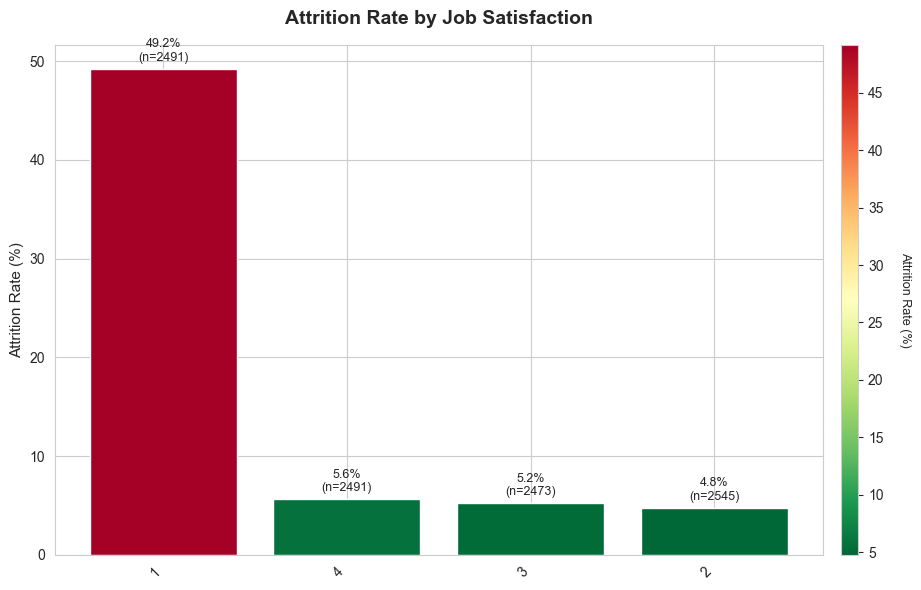

,Category,Total,Attrited,Retained,Attrition_Rate
0,1,2491,1225,1266,49.18
3,4,2491,140,2351,5.62
2,3,2473,129,2344,5.22
1,2,2545,121,2424,4.75


In [115]:
# Cell 6: Single Entry Point - Just Call with Column Name
# Example usage - works for ANY column!

# Categorical columns (no bucketing needed)
plot_attrition(df, 'JobSatisfaction')


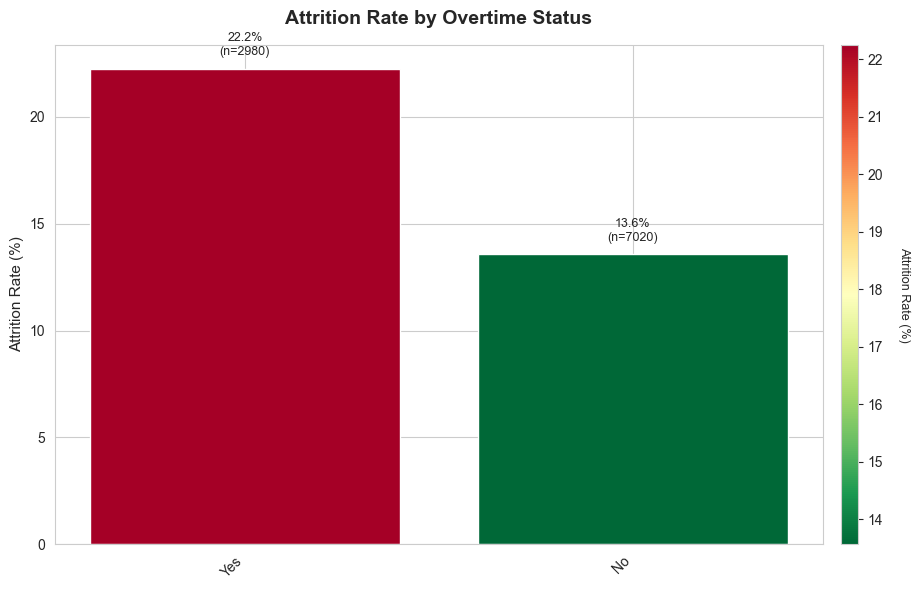

,Category,Total,Attrited,Retained,Attrition_Rate
1,Yes,2980,663,2317,22.25
0,No,7020,952,6068,13.56


In [116]:
plot_attrition(df, 'OverTime')

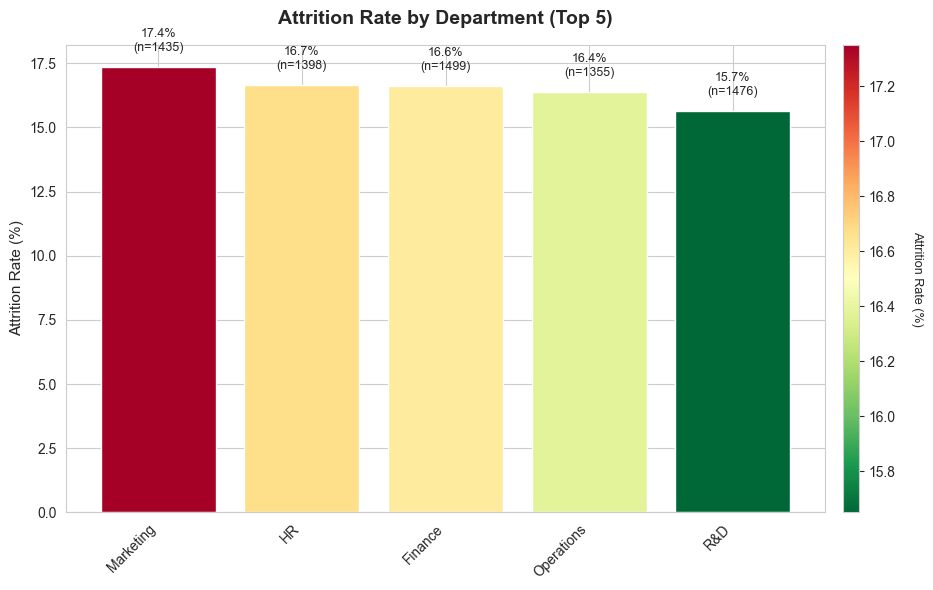

,Category,Total,Attrited,Retained,Attrition_Rate
3,Marketing,1435,249,1186,17.35
1,HR,1398,233,1165,16.67
0,Finance,1499,249,1250,16.61
4,Operations,1355,222,1133,16.38
5,R&D,1476,231,1245,15.65


In [117]:
plot_attrition(df, 'Department', top_n=5)

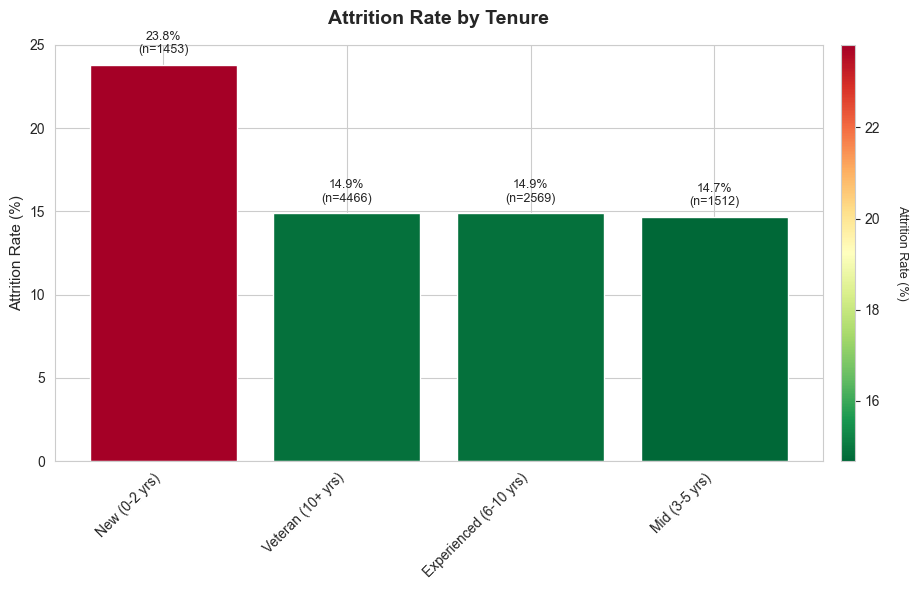

,Category,Total,Attrited,Retained,Attrition_Rate
2,New (0-2 yrs),1453,346,1107,23.81
3,Veteran (10+ yrs),4466,665,3801,14.89
0,Experienced (6-10 yrs),2569,382,2187,14.87
1,Mid (3-5 yrs),1512,222,1290,14.68


In [118]:
plot_attrition(df, 'YearsAtCompany')

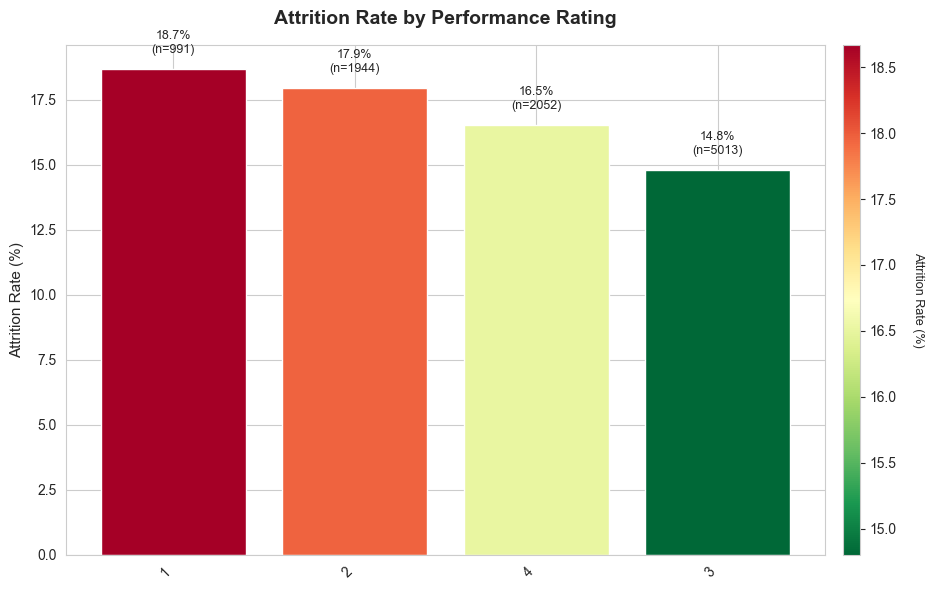

,Category,Total,Attrited,Retained,Attrition_Rate
0,1,991,185,806,18.67
1,2,1944,349,1595,17.95
3,4,2052,339,1713,16.52
2,3,5013,742,4271,14.80


In [119]:
plot_attrition(df, 'PerformanceRating')

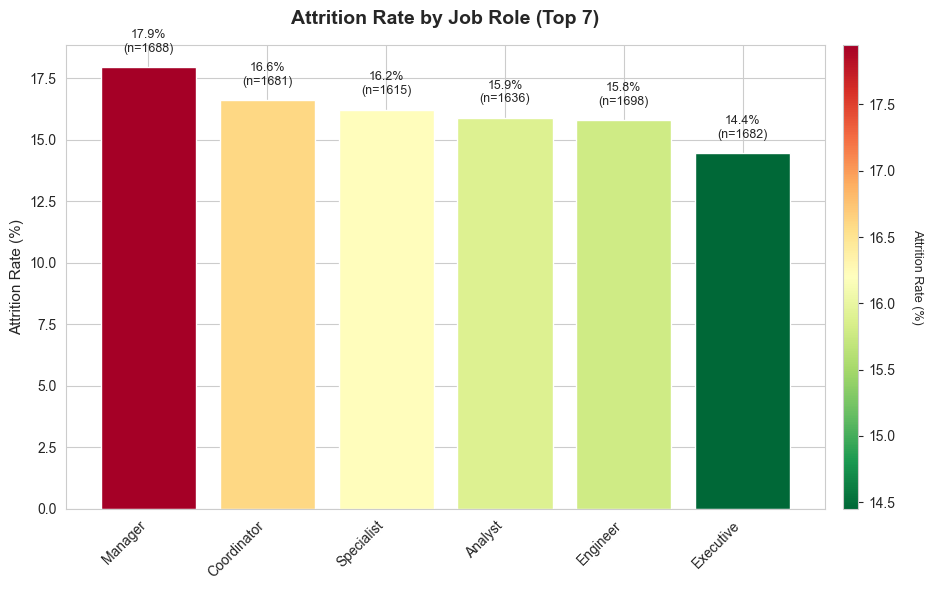

,Category,Total,Attrited,Retained,Attrition_Rate
4,Manager,1688,303,1385,17.95
1,Coordinator,1681,279,1402,16.60
5,Specialist,1615,262,1353,16.22
0,Analyst,1636,260,1376,15.89
2,Engineer,1698,268,1430,15.78
3,Executive,1682,243,1439,14.45


In [ ]:
plot_attrition(df, 'JobRole', top_n=6)